#### Import Libraries
 

In [97]:
# install libraries
#%pip install scikit-learn xgboost mlxtend plotly imbalanced-learn 

 
 

In [98]:
# import libraries

# data manipulation & visulaization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
from mlxtend.plotting import plot_confusion_matrix
import plotly.express as px

# modeling & metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, recall_score,f1_score, roc_auc_score,classification_report, confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV,cross_val_predict
 


#### Helper Functions

In [99]:

def analyse_dataset (df,df_name):
    
    """
    Analyze the given DataFrame and print summary statistics.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to analyze.
    df_name (str): The name of the DataFrame for identification.
    
    Returns:
    None
    """
    
    # Print the shape of the dataset
    print(f"Dataset {df_name} has {df.shape[0]} rows and {df.shape[1]} columns.")
    
    # Count the total number of observations in the dataset and print
    total_observations = df.size
    print(f"Total number of observations in dataset {df_name} are:  {total_observations}")

    # Count the total number of missing values in the dataset and print
    total_null_values = df.isnull().sum().sum()
    print(f"Total number of missing values  present in dataset {df_name} are: {total_null_values}")

    # Calculate the total percentage of missing values in the dataset and print
    total_null_values_percentage = f"{(total_null_values / total_observations * 100):.2f}%"
    print(f"Total percentage of missing values present in dataset {df_name} are:  {total_null_values_percentage}")

In [100]:
def plot_class_distribution(df, target_variable, title):

    """
    Plots the distribution of the target variable in the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the target variable.
    target_variable (str): The name of the target variable column.
    title (str): The title of the plot.
    
    Returns:
    None
    """

    target_distribution = df[target_variable].value_counts()

      
    # Calculate percentages
    total = target_distribution.sum()
    percentages = (target_distribution / total) * 100
    
    # Plot a bar graph
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=target_distribution.index, y=target_distribution.values, palette="mako")
    plt.title(title)
    plt.xlabel(target_variable)
    plt.ylabel("Count")

    # Annotate bars with actual numbers and percentages
    for i, (count, percentage) in enumerate(zip(target_distribution.values, percentages.values)):
        ax.text(i, count, f'{count:,} ({percentage:.2f}%)', ha='center', va='bottom')
    
    # Formatter function to convert y-axis labels to '1k', '2k', etc.
    def y_fmt(x, y):
        return '{:,.0f}k'.format(x / 1000)
    
    plt.gca().yaxis.set_major_formatter(FuncFormatter(y_fmt))

    plt.show()

In [101]:
def plot_uni_variate (df, x_var ):
        """
        Plots the univariate distribution of a variable as a percentage bar chart.
        
        Parameters:
        df (pd.DataFrame): The DataFrame containing the variable.
        x_var (str): The name of the variable to plot.
        
        Returns:
        None
        """
        
  
       # Prepare data
        counts = df[x_var].value_counts(normalize=True) * 100
        order = counts.index

        plt.figure(figsize=(10,6))
        ax = sns.countplot(data=df, x=x_var, order=order, palette="mako")

        # Add percentages
        total = len(df)
        for p in ax.patches:
         percentage = f"{100 * p.get_height() / total:.1f}%"
         ax.annotate(
            percentage,
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha='center',
            va='bottom'
        )

        plt.xticks(rotation=45)
        plt.title(f"Distribution of {x_var}")
        plt.tight_layout()
        plt.show()


In [102]:
def plot_bi_variate(df, x_var, hue_var, title, plot_type='stackedbar'):
    """
    Plots a stacked bar of x_var against hue_var with percentage annotations,
    or a boxplot when plot_type=='boxplot'.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the variables.
    x_var (str): The name of the variable to plot on the x-axis.
    hue_var (str): The name of the variable to use for hue.
    title (str): The title of the plot.
    plot_type (str): 'stackedbar' (default) or 'boxplot'.
    
    Returns:
    None
    """
    
    if plot_type == 'stackedbar':
        # Compute normalized percentage distribution
        data = (
            df.groupby(x_var)[hue_var]
              .value_counts(normalize=True)
              .unstack(fill_value=0)
            * 100
        )

        # # transparent figure background for presentation in slides
        # plt.figure(figsize=(10, 6), facecolor="none")
           
        ax = data.plot(kind='bar', stacked=True, figsize=(10, 6), color=["#392F4F", "#5FB6A4"] )
        
        # get the actual figure used      
        fig = ax.get_figure()     
           
        # transparent figure background  
        fig.patch.set_alpha(0)      
 
        # transparent axes background
        ax.set_facecolor('none')       
        
        plt.title(title)
        plt.ylabel("Percentage (%)")
        plt.xlabel(x_var)
        plt.xticks(rotation=45)
        plt.legend(title=hue_var, loc="upper right")
        plt.ylim(0, 100)

        # Add percentage labels inside bars
        for i, x_class in enumerate(data.index):
            y_offset = 0
            for hue_class in data.columns:
                value = data.loc[x_class, hue_class]
                if value > 4:  # Only annotate if the segment is visible
                    ax.text(
                        i,
                        y_offset + value / 2,
                        f"{value:.1f}%",
                        ha='center', va='center', color='white', fontsize=9
                    )
                y_offset += value

        plt.show()

    elif plot_type == 'boxplot':
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=hue_var, y=x_var, data=df)
        plt.title(f"{x_var} by {hue_var}")
        plt.xlabel(hue_var)
        plt.ylabel(x_var)
        plt.show()

 
    
    else:
        raise ValueError("plot_type must be 'stackedbar' or 'boxplot'")


In [103]:
def stratified_split(df, target_variable, test_size=0.2, random_state=45):
    """
    Splits the DataFrame into stratified training and testing sets based on the target variable, keeping original
    class distribution.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to split.
    target_variable (str): The name of the target variable column.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Random seed for reproducibility.
    
    Returns:
    train_dataset (pd.DataFrame): The training dataset.
    test_dataset (pd.DataFrame): The testing dataset.
    """
    
    # Create a deep copy of the original dataframe
    dataset = df.copy(deep=True)
    
    # Split the dataframe into features (X) and target variable (y)
    X = dataset.drop(target_variable, axis=1)
    y = dataset[target_variable]

    # Split the data into training and test sets  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,stratify=dataset[target_variable], random_state=random_state)

    # Print the shapes of the resulting dataframes
    print("Training data shape: ", X_train.shape, y_train.shape)
    print("Test data shape: ", X_test.shape, y_test.shape)

    # Summarize the train dataset
    train_dataset = pd.concat([X_train, y_train], axis=1)
    train_dataset.head()


    print("Number of instances and features in training dataset: ", train_dataset.shape)
    print("Number of non-churned customers: ", y_train.value_counts()[0])
    print("Number of churned customers: ", y_train.value_counts()[1])

    #  Summarize the testing dataset
    test_dataset = pd.concat([X_test, y_test], axis=1)
    print("Number of instances and variables in testing dataset: ", test_dataset.shape)
    print("Number of non-churned customers: ", y_test.value_counts()[0])
    print("Number of churned customers: ", y_test.value_counts()[1])

    # Calculate the percentages of each class in the train dataset
    train_class_percentages = y_train.value_counts() / len(y_train)
    print("Percentages of each class in the train dataset: \n" , round(train_class_percentages * 100,2) )

    # Calculate the percentages of each class in the test dataset
    test_class_percentages = y_test.value_counts() / len(y_test)
    print("Percentages of each class in the test dataset: \n" , round(test_class_percentages * 100,2) )

    return train_dataset, test_dataset

In [104]:
    # Function to plot feature importance based on RandomForestClassifier
def plot_feature_importance(rf, features_names, no_features=5) :
 
        """
        Plots the feature importance of the top 'no_features' features from a RandomForestClassifier.
        
        Parameters:
        rf (RandomForestClassifier): The trained RandomForestClassifier model.
        features_names (list): List of feature names corresponding to the model's input features.
        no_features (int): Number of top features to display (default is 5).
        
        Returns:
        None
        """
        
         
        
        #Create arrays from feature importance and feature names
        feature_importance = np.array(rf.feature_importances_)
        feature_names = np.array(features_names)  

        #Create a DataFrame using a Dictionary
        data={'feature_names':feature_names,'feature_importance':feature_importance}
        fi_df = pd.DataFrame(data)

        #Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

        
        # Select the top no_features features
        top_features = fi_df.head(no_features)
        
        # Plotting the top 20 features in horizontal arrangement
        plt.figure(figsize=(10, 8))
        sns.barplot(x='feature_importance', y='feature_names', data=top_features, orient='h')
        plt.title('Top Features Importance by Random Forest Classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Name')
        plt.show()

In [105]:
def print_confusion_matrix (test_target, test_prediction):
        """
        Plots the confusion matrix for the given test target and predictions.
        
        Parameters:
        test_target (pd.Series or np.array): The true target values.
        test_prediction (pd.Series or np.array): The predicted target values.
        
        Returns:
        None
        """
        
        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(test_target,test_prediction)
        
        # Print the confusion matrix using mlxtend.plotting
        fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Blues)
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.show()
 

In [106]:
def plot_sklearn_roc_curve(test_target, test_pred_prob, roc_auc):

         """
         Plots the ROC curve using Plotly for the given test target and predicted probabilities.
         
         Parameters:
         test_target (pd.Series or np.array): The true target values.
         test_pred_prob (pd.Series or np.array): The predicted probabilities for the positive class.
         roc_auc (float): The ROC AUC score.
         
         Returns:
         None
         """
         
         
        # Pass actual target and prediction for test dataset and return FPR and TPR
         fpr, tpr, threshold = roc_curve(test_target, test_pred_prob)

         roc_data = pd.DataFrame({
          'False Positive Rate': fpr,
          'True Positive Rate': tpr,
          'Threshold': threshold
                             })
            # Display the ROC Curve
         fig = px.area(
         roc_data,
         x='False Positive Rate',
         y='True Positive Rate',
         title=f'ROC Curve (AUC={roc_auc:.4f})',
         labels=dict(x='False Positive Rate', y='True Positive Rate'),
         width=700, height=500,
         hover_data={'Threshold': True}  # Add threshold to hover data
          )   

         fig.add_shape(
           type='line', line=dict(dash='dash'),
           x0=0, x1=1, y0=0, y1=1
              )

         fig.update_yaxes(scaleanchor="x", scaleratio=1)
         fig.update_xaxes(constrain='domain')
         fig.show()

In [107]:
def fit_model (model, features_df, target_ps):
    """
    Fits the given model to the features set and target, 
    

    Parameters:
    model: The machine learning model to fit.
    features_df (pd.DataFrame): The features set.
    target_ps (pd.Series): The target variable.
    

    Returns:
    fitted_model: The fitted machine learning model.
    """
    
 
    fitted_model = model.fit(features_df, target_ps)
    
       

    return fitted_model

In [108]:
def evaluate_model (fitted_model, features_df, target_ps, data_split="test",doPrint=False):
    """
    Evaluates the fitted performance with different metrics on specified data split.

    Parameters:
    fitted_model: The fitted machine learning model.
    features_df (pd.DataFrame): The features set.
    target_ps (pd.Series): The target variable.
    doPrint (boolean): Flag to determine whether to print the different metrics

    Returns:
    accuracy (float): Test accuracy score.
    recall (float): Test recall score.
    f1 (float): Test F1 score.
    roc_auc (float): Test ROC-AUC score.
    """
         
 
    # predictions
    predictions = fitted_model.predict(features_df)
    pred_proba = fitted_model.predict_proba(features_df)[:, 1]
       
    # metrics
    accuracy = accuracy_score(target_ps, predictions)
    recall = recall_score(target_ps, predictions)
    f1 = f1_score(target_ps, predictions)
    roc_auc = roc_auc_score(target_ps, pred_proba)
           
    if doPrint==True:
 
          print(f"{data_split} Metrics")
          print("=" * 50) 
          print(f"{data_split} Accuracy: {accuracy:.4f}")        
          print(f"{data_split} Recall: {recall:.4f}")        
          print(f"{data_split} F1 Score: {f1:.4f}")        
          print(f"{data_split}  ROC-AUC Score: {roc_auc:.4f}")
          print("\n" + "=" * 50)
          print(f"{data_split}  Classification Report")
          print("=" * 50)
          print ("\n\n")
          print(classification_report(target_ps, predictions))
          print_confusion_matrix(target_ps, predictions)
          plot_sklearn_roc_curve(target_ps, pred_proba, roc_auc)

    return accuracy, recall, f1, roc_auc 

In [109]:
def fit_evaluate_model_cv (model, features_df, target_ps):
    """
    Cross-validate the given model using 5-fold 
    and evaluates its performance with different metrics

    Parameters:
    
    model: The machine learning model to fit.
    features_df (pd.DataFrame): The features set.
    target_ps (pd.Series): The target variable.
    

    Returns:
    accuracy (float): Test accuracy score.
    recall (float): Test recall score.
    f1 (float): Test F1 score.
    roc_auc (float): Test ROC-AUC score.
    fitted_model: The fitted machine learning model.
    """
    
    # calculate metrics with cross-validation
 
    predictions = cross_val_predict (model, features_df, target_ps,cv=5, method="predict")
    pred_proba = cross_val_predict (model, features_df, target_ps,cv=5, method="predict_proba")
    accuracy = accuracy_score(target_ps, predictions)
    recall = recall_score(target_ps, predictions)
    f1 = f1_score(target_ps, predictions)
    roc_auc = roc_auc_score(target_ps, pred_proba[:, 1])
         
    
  

    return accuracy, recall, f1, roc_auc

#### 1. Data Collection

##### 1.1 Read csv file dataset into pandas dataframe

In [110]:
# Excel file was converted to CSV for easier handling, give possible missing values
df_raw_churn = pd.read_csv ("customer_churn.csv", na_values=["", " ", "NA", "N/A"])

print (df_raw_churn.head())

   CustomerID  Gender Senior Citizen Partner Dependents  Tenure Months  \
0  3668-QPYBK    Male             No      No         No              2   
1  9237-HQITU  Female             No      No        Yes              2   
2  9305-CDSKC  Female             No      No        Yes              8   
3  7892-POOKP  Female             No     Yes        Yes             28   
4  0280-XJGEX    Male             No      No        Yes             49   

  Phone Service Multiple Lines Internet Service Online Security  ...  \
0           Yes             No              DSL             Yes  ...   
1           Yes             No      Fiber optic              No  ...   
2           Yes            Yes      Fiber optic              No  ...   
3           Yes            Yes      Fiber optic              No  ...   
4           Yes            Yes      Fiber optic              No  ...   

  Device Protection Tech Support Streaming TV Streaming Movies  \
0                No           No           No           

In [111]:
# get general info about the dataset, columns, data types, non-null counts etc.
df_raw_churn.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Gender             7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure Months      7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [112]:
analyse_dataset (df_raw_churn,"Customer Churn Dataset")

Dataset Customer Churn Dataset has 7043 rows and 21 columns.
Total number of observations in dataset Customer Churn Dataset are:  147903
Total number of missing values  present in dataset Customer Churn Dataset are: 11
Total percentage of missing values present in dataset Customer Churn Dataset are:  0.01%


##### 1.2 Initial data cleansing

In [113]:
# convert column names to remove spaces and replace with underscores and lowercase for easier handling
df_raw_churn.columns = df_raw_churn.columns.str.replace(' ', '_').str.lower()

# convert target variable 'churn' to binary 0 and 1 and assign to new column 'is_churned'
df_raw_churn['is_churned'] = df_raw_churn['churn_label'].apply(lambda x: 1 if x == 'Yes' else 0)

# remove unnecessary columns
columns_to_remove = ['customerid']
df_raw_churn = df_raw_churn.drop(columns=columns_to_remove)


#### 2. Exploratory Data Analysis (EDA)

In [114]:
# copy the original dataframe for visualizations
df_temp = df_raw_churn.copy()
# get summary statistics for numerical columns
df_temp.describe()

,tenure_months,monthly_charges,total_charges,is_churned
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.265370
std,24.559481,30.090047,2266.771362,0.441561
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.850000,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


##### 2.1 Missing Values

In [115]:
# check for missing values
df_temp.isnull().sum()


gender                0
senior_citizen        0
partner               0
dependents            0
tenure_months         0
phone_service         0
multiple_lines        0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
contract              0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
churn_label           0
is_churned            0
dtype: int64

* Most columns has no missing values, only total_charges has some missing values, we will check what are those,
  churn_reason has missing values for non-churned customers which is expected.

In [116]:
df_temp[np.isnan(df_temp['total_charges'])]

,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn_label,is_churned
2234,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0
2438,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No,0
2568,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No,0
2667,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No,0
2856,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No,0
4331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No,0
4687,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No,0
5104,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No,0
5719,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No,0
6772,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,...,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No,0


* From the previous data, we can see there is 11 customers with null values for total charges, although monthly charges is greater than zero. Also noticed that the tenure is 0 so these are new customers who have been registered for less than a month, and they are all not churned 
* Next, I will check if there is any other 0 values for tenur

In [117]:
# check for rows with tenure_months equal to 0
df_temp [df_temp['tenure_months'] == 0]

,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn_label,is_churned
2234,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,0
2438,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No,0
2568,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No,0
2667,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No,0
2856,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No,0
4331,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No,0
4687,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No,0
5104,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No,0
5719,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No,0
6772,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,...,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No,0


* so no other rows found

##### 2.3 Customer Churn Distribution

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\2510067654.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_distribution.index, y=target_distribution.values, palette="mako")


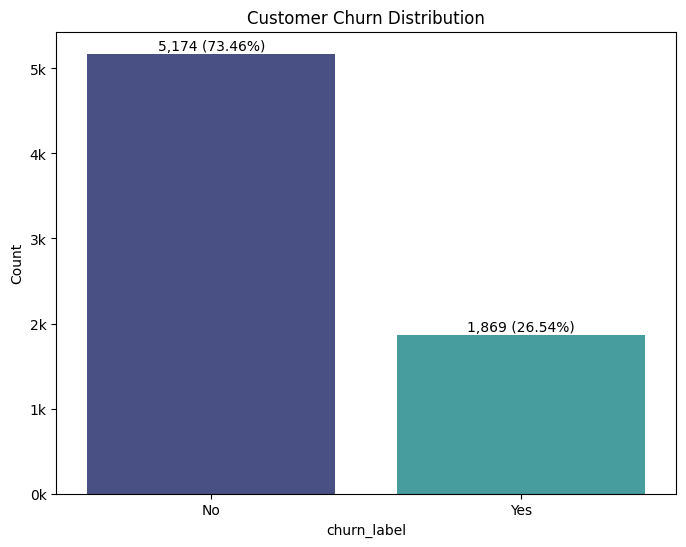

In [118]:
# Plot class distribution for churn_label against online_security
plot_class_distribution (df_temp, "churn_label", "Customer Churn Distribution")

* So we have a slightly imbalanced dataset - majority class (non-churned) : 73.46%  / minority class (churned) : 26.54% , so we might need to use some balancing technique to improve predictions

##### 2.4 Chrurn Drivers Analysis

* So below, I will calculate churn rates across different customer segments, to get an overview of the most important factors that drive churn

In [119]:
import numpy as np

# create some derived features that can help show some patterns

# create tenure buckets
 
df_temp["tenure_bucket"] = pd.cut(
    df_temp["tenure_months"],
    bins=[0, 1, 3, 6, 12, 24, 36, 48, np.inf],
    labels=["less than 1", "1-3", "3-6", "6-12", "12-24", "24-36", "36-48", "48+"],
    right=False,
    include_lowest=True
)

# create monthly charges quartiles
 
df_temp['monthly_charges_quartile'] = pd.qcut(
    pd.to_numeric(df_temp['monthly_charges'], errors='coerce'),
    4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)']
)

df_temp["charge_bucket"] = pd.cut(
    df_temp["monthly_charges"],
    bins=[0, 30, 60, 90, np.inf],
    labels=['0–30', '30–60', '60–90', '90+'],
    right=False,
    include_lowest=True
)
 
 

# create a new feature 'service_combo' based on phone_service and internet_service
phone = df_temp['phone_service'].str.lower().eq('yes')
internet = df_temp['internet_service'].str.lower().ne('no')

df_temp['service_combo'] = np.select(
    [
        internet & ~phone,
        phone & ~internet,
        internet & phone
    ],
    [
        'Internet only',
        'Phone only',
        'Both'
    ],
    default='No service'
)
 


df_temp


,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,...,paperless_billing,payment_method,monthly_charges,total_charges,churn_label,is_churned,tenure_bucket,monthly_charges_quartile,charge_bucket,service_combo
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,Yes,Mailed check,53.85,108.15,Yes,1,1-3,Q2,30–60,Both
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,Yes,Electronic check,70.70,151.65,Yes,1,1-3,Q3,60–90,Both
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,Yes,Electronic check,99.65,820.50,Yes,1,6-12,Q4 (high),90+,Both
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Electronic check,104.80,3046.05,Yes,1,24-36,Q4 (high),90+,Both
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,48+,Q4 (high),90+,Both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,...,Yes,Bank transfer (automatic),21.15,1419.40,No,0,48+,Q1 (low),0–30,Phone only
7039,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Mailed check,84.80,1990.50,No,0,24-36,Q3,60–90,Both
7040,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,Credit card (automatic),103.20,7362.90,No,0,48+,Q4 (high),90+,Both
7041,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,Yes,Electronic check,29.60,346.45,No,0,6-12,Q1 (low),0–30,Internet only


In [120]:
rows = []

# get list of categorical columns excluding target and churn reason columns
categorical_cols = df_temp.select_dtypes(include=['object', 'category']).columns.drop(['churn_label'])
 
# calculate churn rate for each category in categorical columns
for col in categorical_cols:
    temp = (
        df_temp.groupby(col)['churn_label']
          .apply(lambda x: (x == 'Yes').mean())
          .reset_index()
          .rename(columns={'churn_label': 'churn_rate'})
    )
    temp['feature'] = col
    temp = temp[['feature', col, 'churn_rate']]
    temp = temp.rename(columns={col: 'category'})
    rows.append(temp)

# concatenate all the results into a single DataFrame
churn_table = pd.concat(rows, ignore_index=True)

# sort the churn table by churn rate in descending order
churn_table.sort_values(by='churn_rate', ascending=False, inplace=True)

churn_table.to_csv("churn_rate_by_category.csv", index=False)

churn_table


C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\4232826628.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(col)['churn_label']
C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\4232826628.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.groupby(col)['churn_label']
C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\4232826628.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp.group

,feature,category,churn_rate
44,tenure_bucket,1-3,0.591069
45,tenure_bucket,3-6,0.473477
41,payment_method,Electronic check,0.452854
34,contract,Month-to-month,0.427097
14,internet_service,Fiber optic,0.418928
...,...,...,...
26,tech_support,No internet service,0.074050
61,service_combo,Phone only,0.074050
7,dependents,Yes,0.065151
36,contract,Two year,0.028319


* We can see from the previous table that the churn rate was the highest (%59) among customers in the 1-3 months after buying the service , followed by  (%47) among customers in the 3-6 months, followed by customer who paid by electronic check at (%45), then by customer on a monthly contract at (%42), followed by who has fiber internet (%41), who has no internet security (%41), and senior citzens (%41) 

* While customers who were a two-year contract or had dependants had the lowest churn rates, with churn rates of only (%2) and (%6), respectively.

In [121]:
# mapping from (feature, original category) -> modified_category for better readability
mods = {
    ('tenure_bucket', '1-3'): '1-3 Month Tenure',
    ('tenure_bucket', '3-6'): '3-6 Month Tenure',
    ('payment_method', 'Electronic check'): 'Electronic Check',
    ('contract', 'Month-to-month'): 'Monthly Contract',
    ('internet_service', 'Fiber optic'): 'Fiber Optic',
    ('online_security', 'No'): 'No Online Security',
    ('senior_citizen', 'Yes'): 'Senior Citizen',
    ('tech_support', 'No'): 'No Tech Support',
    ('online_backup', 'No'): 'No Online Backup',
    ('device_protection', 'No'): 'No Device Protection',
    ('contract', 'One year'): 'One Year Contract',
    ('service_combo', 'Phone only'): 'Phone Service Only',
    ('dependents', 'Yes'): 'Has Dependants',
    ('contract', 'Two year'): 'Two Year Contract',
}

# apply mapping and filter
tmp = churn_table.copy()
tmp['modified_category'] = tmp.apply(
    lambda r: mods.get((r['feature'], r['category'])), axis=1
)

# keep only the mapped rows
churn_table_mod = tmp[tmp['modified_category'].notna()][
    ['feature', 'category', 'modified_category', 'churn_rate']
]
 
churn_table_mod

,feature,category,modified_category,churn_rate
44,tenure_bucket,1-3,1-3 Month Tenure,0.591069
45,tenure_bucket,3-6,3-6 Month Tenure,0.473477
41,payment_method,Electronic check,Electronic Check,0.452854
34,contract,Month-to-month,Monthly Contract,0.427097
14,internet_service,Fiber optic,Fiber Optic,0.418928
16,online_security,No,No Online Security,0.417667
3,senior_citizen,Yes,Senior Citizen,0.416813
25,tech_support,No,No Tech Support,0.416355
19,online_backup,No,No Online Backup,0.399288
22,device_protection,No,No Device Protection,0.391276


C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\3634790705.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


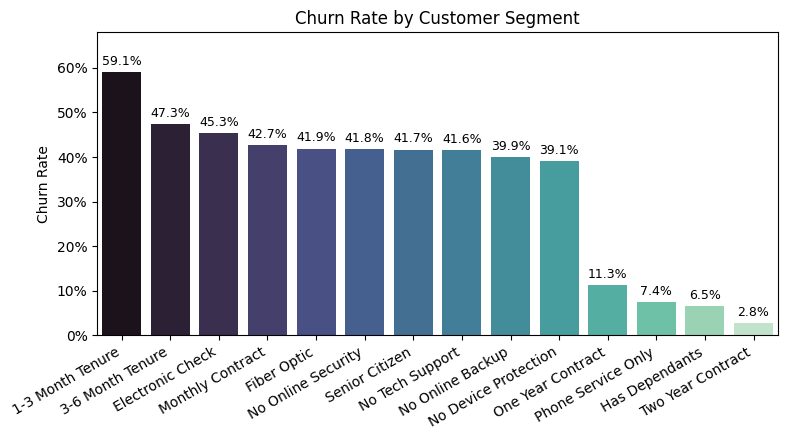

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(8, 4.5), facecolor='none')

ax = sns.barplot(
    data=churn_table_mod.sort_values('churn_rate', ascending=False),
    x='modified_category',
    y='churn_rate',
    palette='mako'
)

# ensure some headroom for labels and format y-axis as percentages
ax.set_ylim(0, churn_table_mod['churn_rate'].max() * 1.15)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.set_ylabel('Churn Rate')
ax.set_xlabel('')
ax.set_title('Churn Rate by Customer Segment')

# make axes background transparent
ax.set_facecolor('none')    

# ensure patch is fully transparent
ax.patch.set_alpha(0.0)         

 
 
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1%}", (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


##### 2.5 Data Visualization

* So below, I will visualize some features that could potentially have an impact on customer churn based on the previous calculated churn rates

##### 2.5.1 Univariate Analysis

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\3201358179.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_var, order=order, palette="mako")


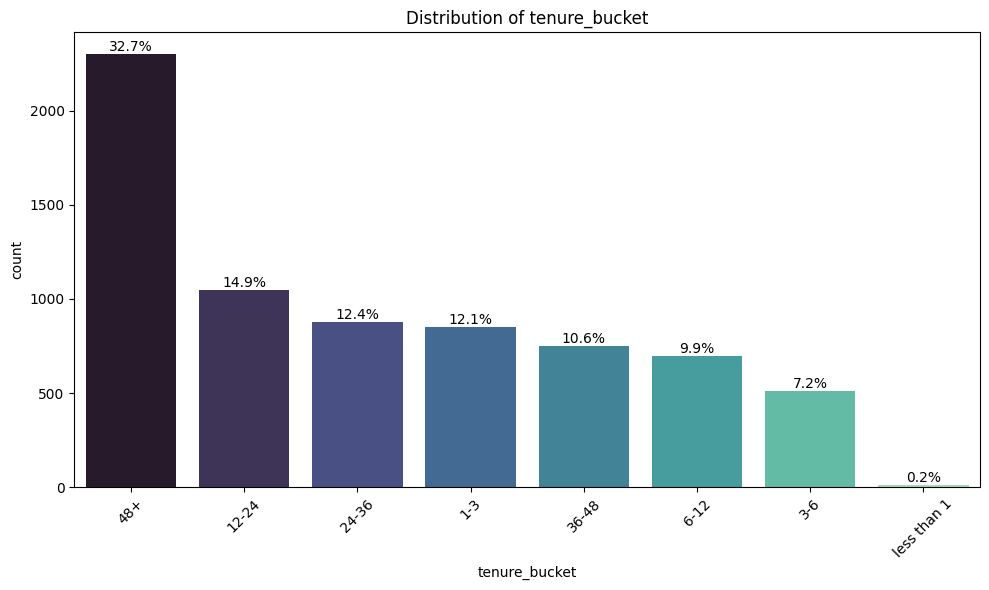

In [123]:
plot_uni_variate (df_temp, "tenure_bucket" )

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\3201358179.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_var, order=order, palette="mako")


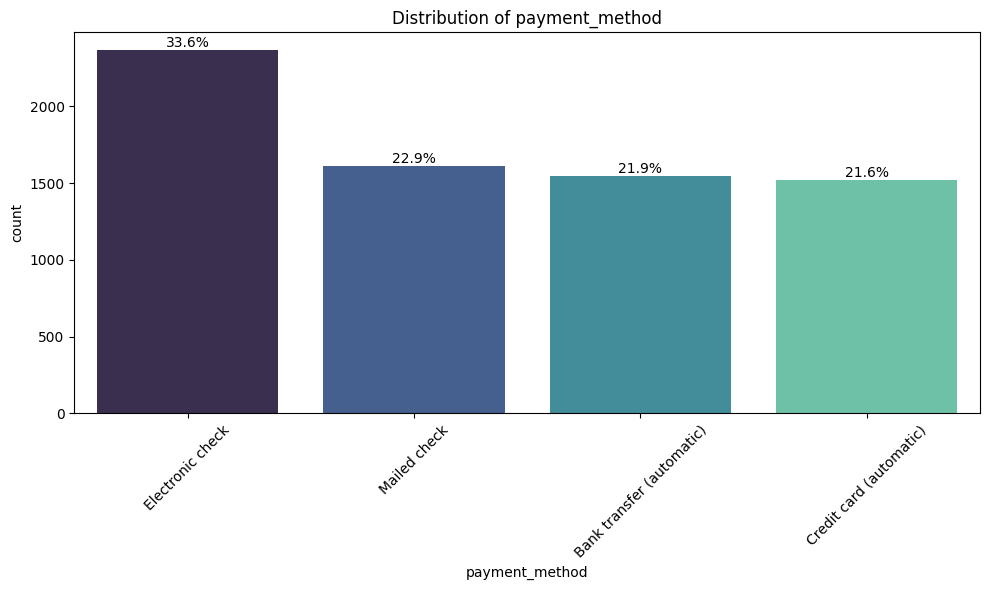

In [124]:
plot_uni_variate (df_temp, "payment_method" )


* A little more than one third of customers pay by electronic check which has the highest churn rate

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\3201358179.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_var, order=order, palette="mako")


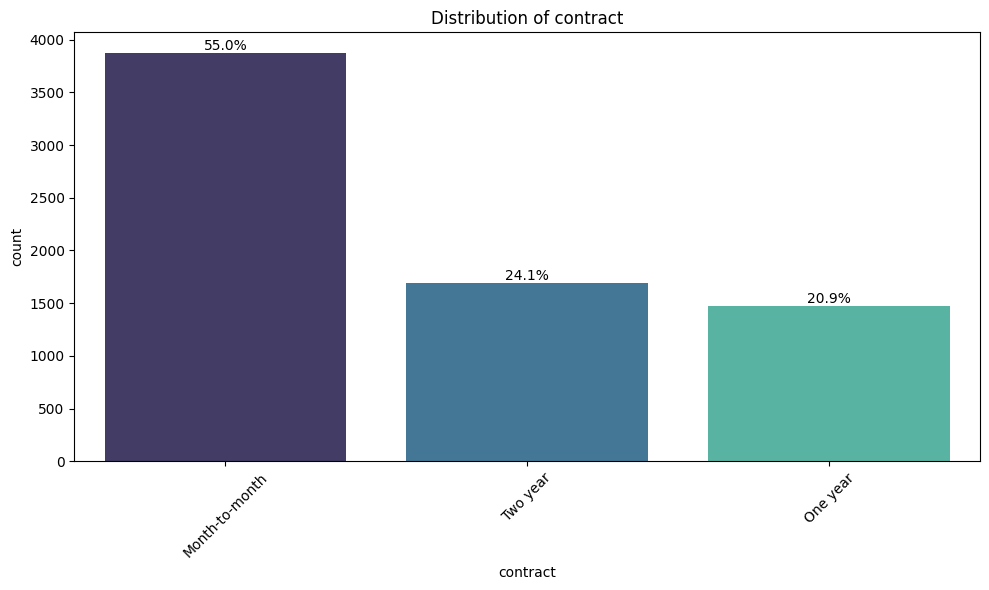

In [125]:
plot_uni_variate (df_temp, "contract" )

* more than half of customers (55%) are on monthly contract who tend to have higher risk of churn

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\3201358179.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_var, order=order, palette="mako")


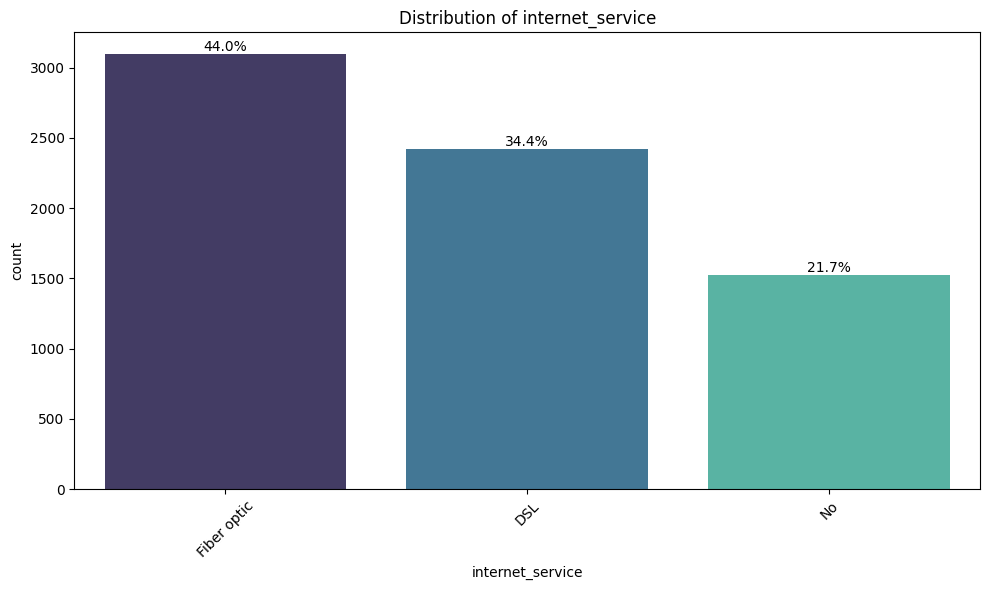

In [126]:
plot_uni_variate (df_temp, "internet_service" )

* 44% of customers have fiber optic and they have double the churn rate of DSL, and 5x more than who don't have internet service

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\3201358179.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=x_var, order=order, palette="mako")


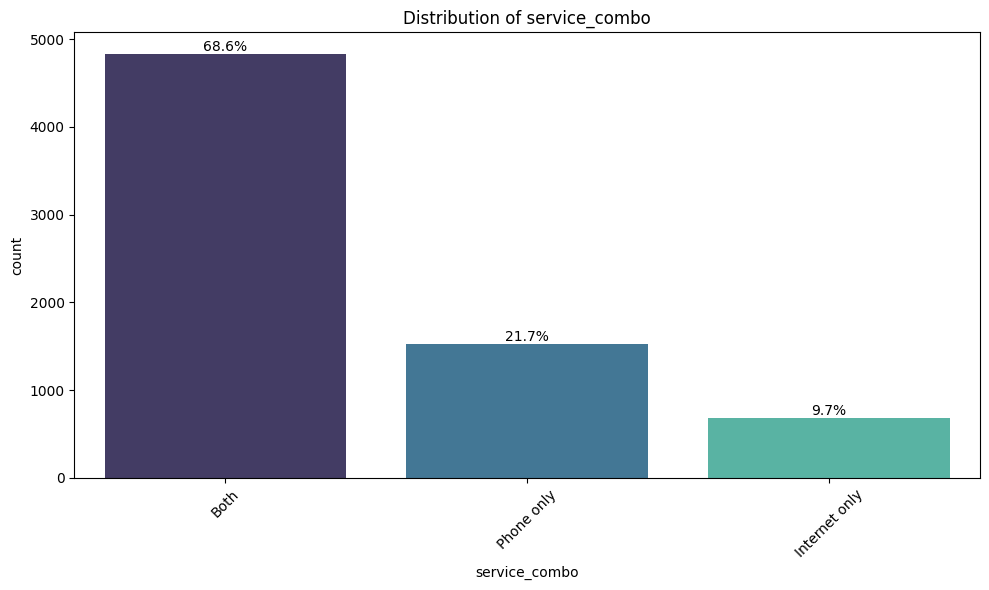

In [127]:
plot_uni_variate (df_temp, "service_combo" )

* Majority of customers (68%) have both phone and itnernet services, and this segement have a higer risk of churn (32%) in comparison to internet only (%25) or phone only (%7)

##### 2.5.2 Bivariate Analysis

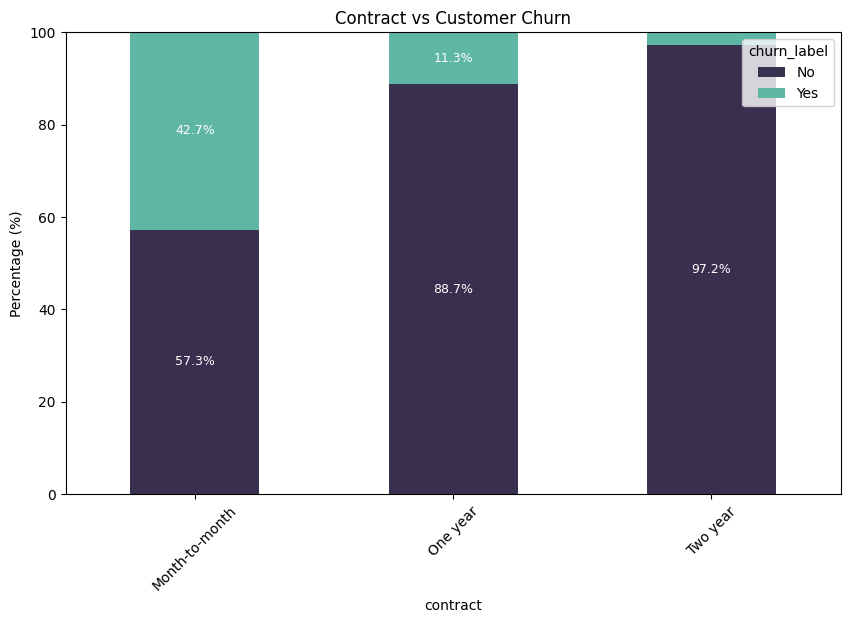

In [128]:
plot_bi_variate (df_temp, "contract", "churn_label", "Contract vs Customer Churn")

* customers who are on a monthly contract have a significant higher churn rate that those on long term contracts (1y, 2y)

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\2936262108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(x_var)[hue_var]


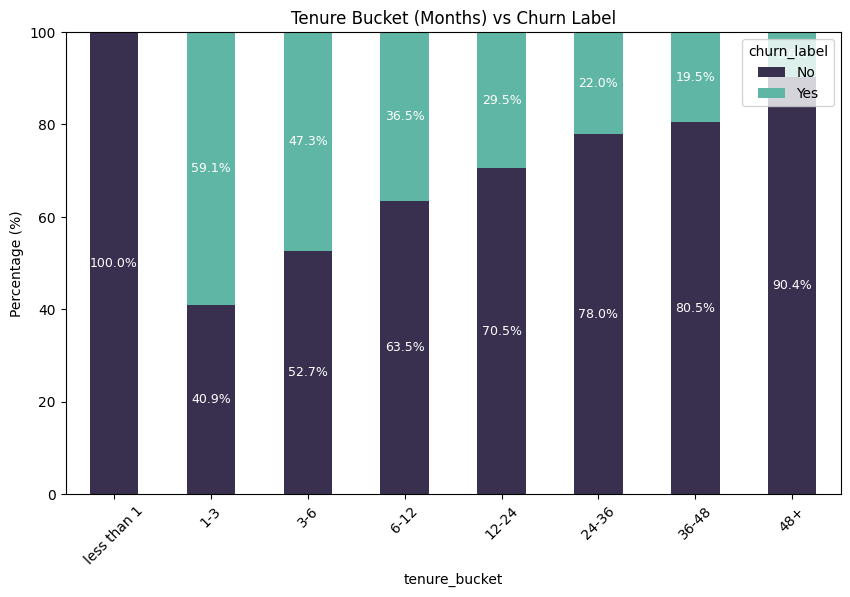

In [129]:
plot_bi_variate (df_temp, "tenure_bucket", "churn_label", "Tenure Bucket (Months) vs Churn Label", plot_type='stackedbar')

* customer are more likely to churn during the first 3 months , and this risk decreases with the longer time stays as a customer

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\2054911075.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df_temp.groupby("tenure_bucket")["is_churned"].mean().reset_index()
C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\2054911075.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="tenure_bucket", y="churn_pct", data=tenure_churn, palette="mako")


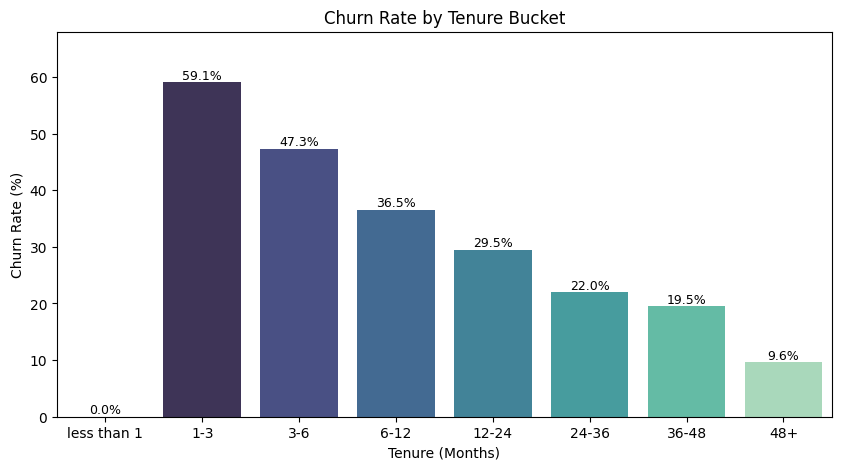

In [130]:
# Calculate churn rate per bucket and convert to percentage
tenure_churn = df_temp.groupby("tenure_bucket")["is_churned"].mean().reset_index()
tenure_churn["churn_pct"] = tenure_churn["is_churned"] * 100

plt.figure(figsize=(10,5))
ax = sns.barplot(x="tenure_bucket", y="churn_pct", data=tenure_churn, palette="mako")
plt.title("Churn Rate by Tenure Bucket")
plt.xlabel("Tenure (Months)")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, tenure_churn["churn_pct"].max() * 1.15)

# Annotate bars with percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1f}%", (p.get_x() + p.get_width() / 2, height),
                ha="center", va="bottom", fontsize=9)

plt.grid(axis="y",linestyle="none", alpha=0.5)
plt.show()

* churn rate decrease sginificantly with the customer tenure from 59.1% at the 1-3 months to 9.6% for tenure 48+ months

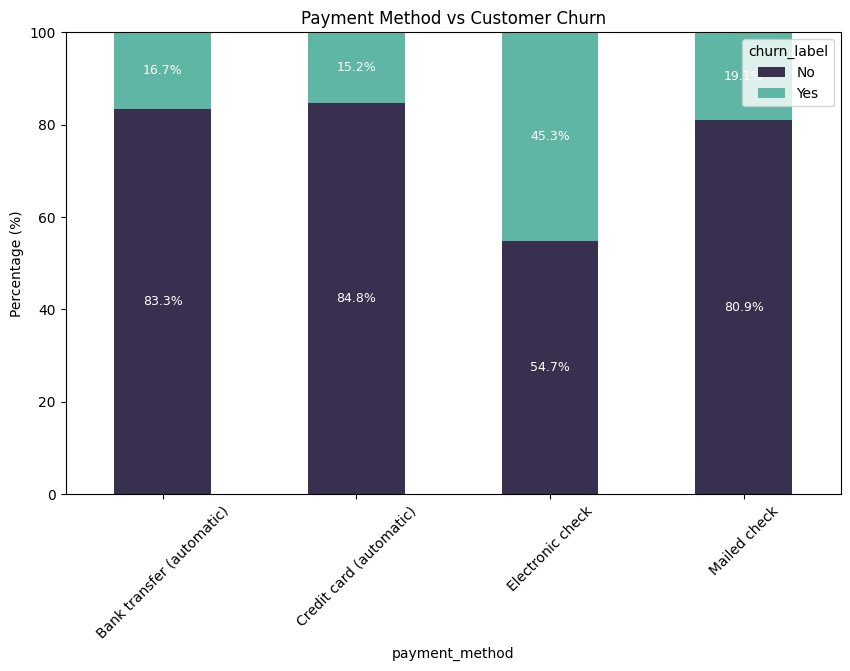

In [131]:
plot_bi_variate (df_temp, "payment_method", "churn_label", "Payment Method vs Customer Churn")

* customers who pay by electronic check have the highest churn rate (45%), while customer who pay through credit card have the least churn rate (%15)

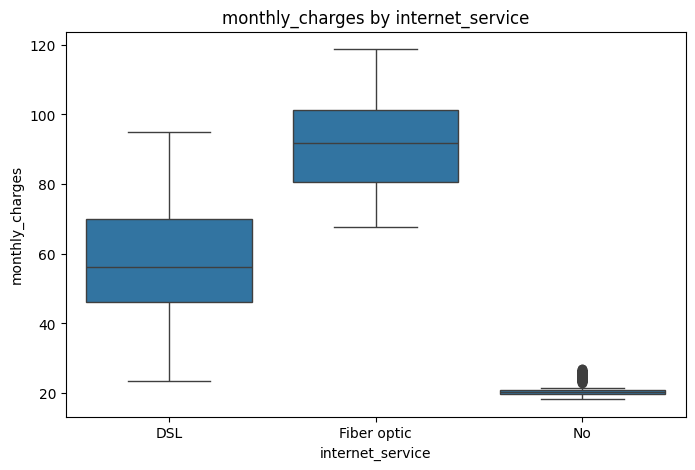

In [132]:
plot_bi_variate (df_temp,'monthly_charges', 'internet_service', 'test', plot_type='boxplot')

* we can see the fibre optic customers has much higher monthly charges than DSL and than those of who don't have internet service, so fibre optic is a high-value segment.

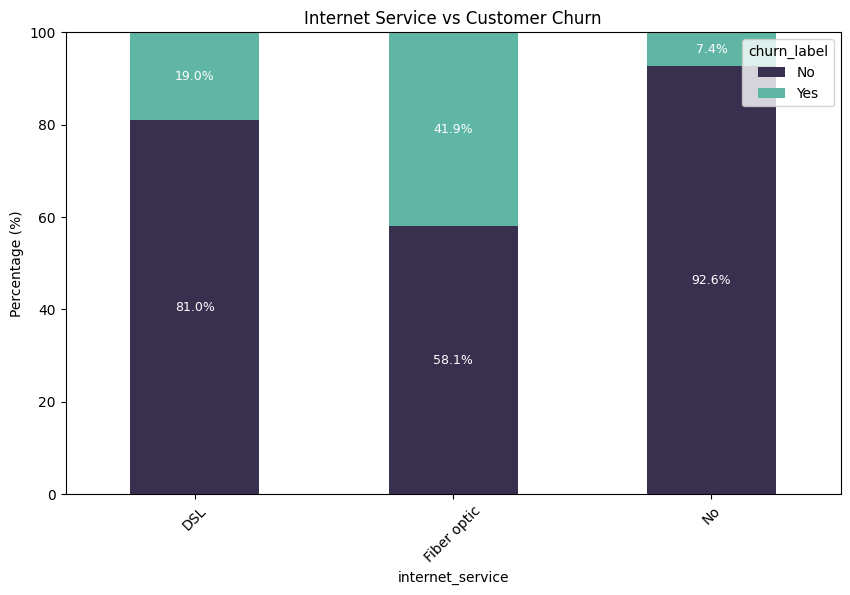

In [133]:
plot_bi_variate (df_temp, "internet_service", "churn_label", "Internet Service vs Customer Churn")

* We can see people who has fiber optic service are more likely to churn than DSL, and people with no internet service are the least likely to churn

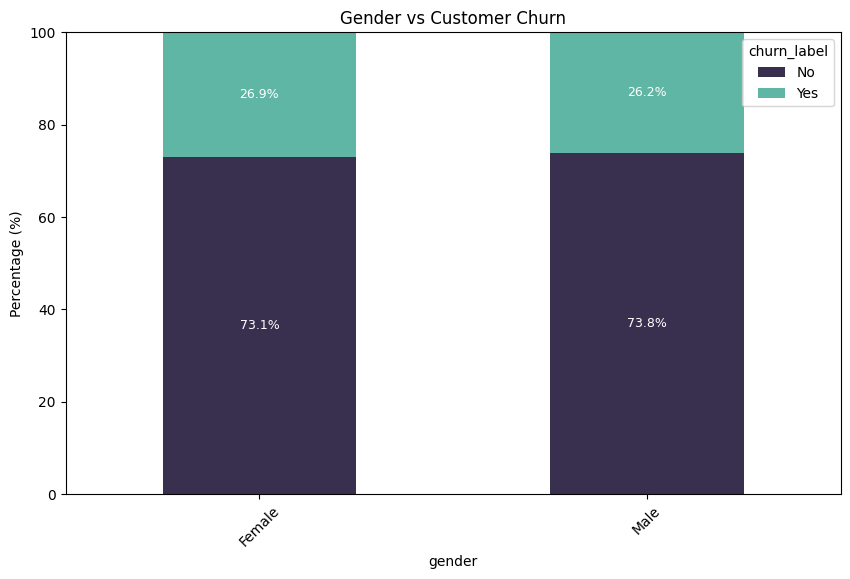

In [134]:

# Plot class distribution for churn_label against gender
plot_bi_variate (df_temp, "gender", "churn_label", "Gender vs Customer Churn")

* So from the plot above, we can see that there is no significant difference in churn rate between male and female customers. 

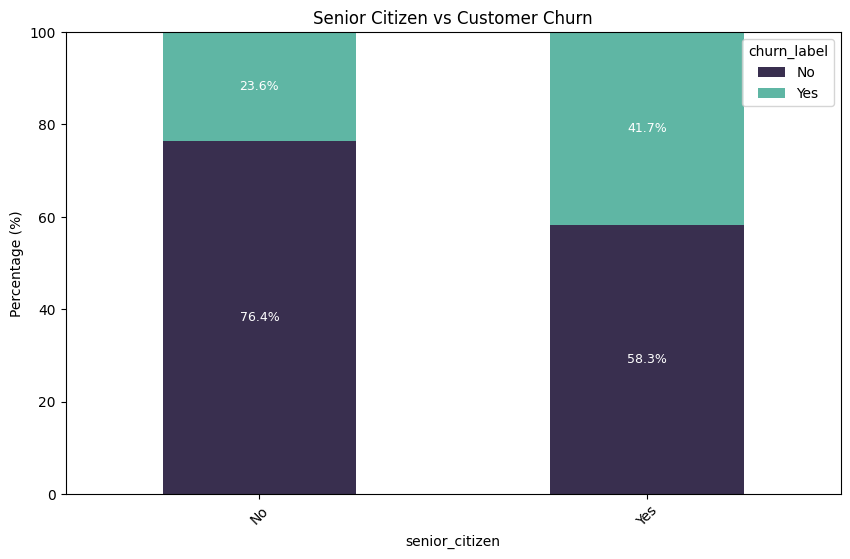

In [135]:
# Plot class distribution for churn_label against senior_citizen
plot_bi_variate (df_temp, "senior_citizen", "churn_label", "Senior Citizen vs Customer Churn")

* We can see that senior citizens have higher churn rate than non-senior citizens.

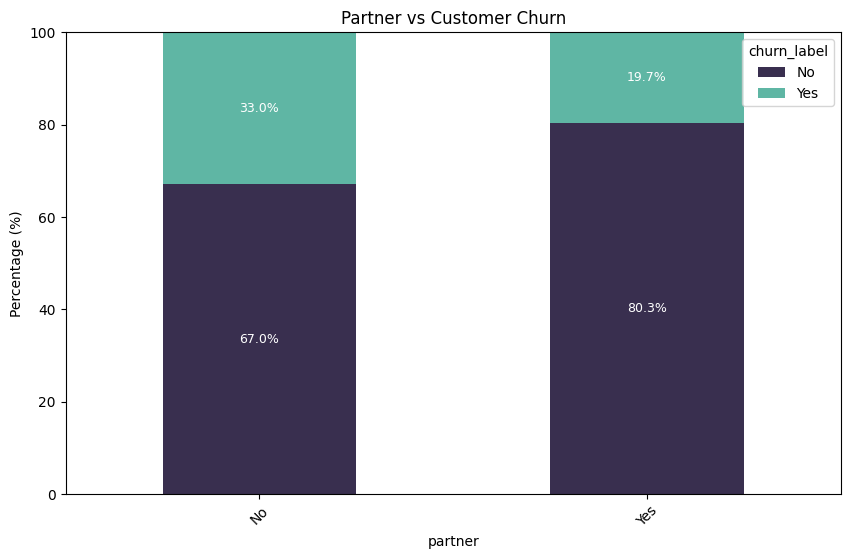

In [136]:
# Plot class distribution for churn_label against partner
plot_bi_variate (df_temp, "partner", "churn_label", "Partner vs Customer Churn")

* We can see that people who have partners are less likely to churn

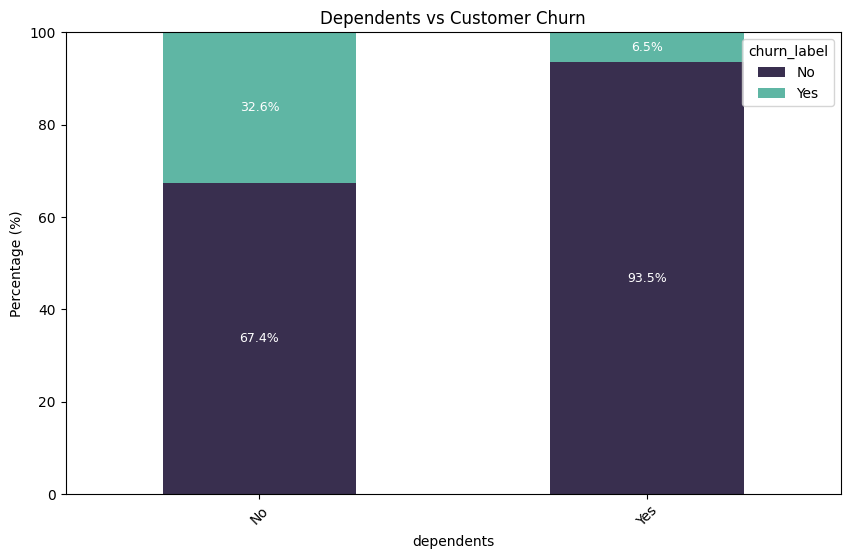

In [137]:
# Plot class distribution for churn_label against dependents
plot_bi_variate (df_temp, "dependents", "churn_label", "Dependents vs Customer Churn")

* We can see that people who have dependants are less likely to churn

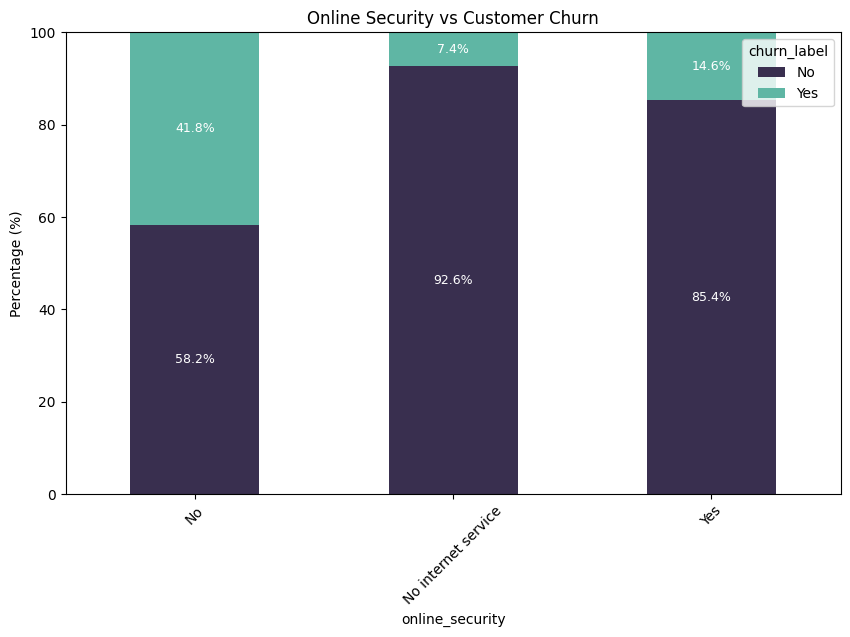

In [138]:
# Plot class distribution for churn_label against online_security
plot_bi_variate (df_temp, "online_security", "churn_label", "Online Security vs Customer Churn")



* Customers who does not have online security are more likely to churn than those who have

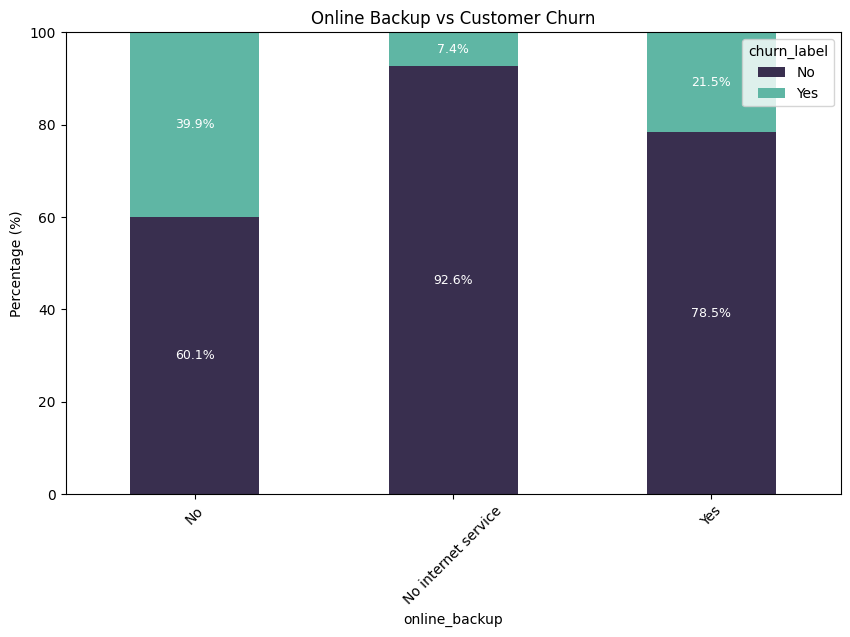

In [139]:
# Plot class distribution for churn_label against online_backup
plot_bi_variate (df_temp, "online_backup", "churn_label", "Online Backup vs Customer Churn")

* Customers who does not have online backup are more likely to churn than those who have

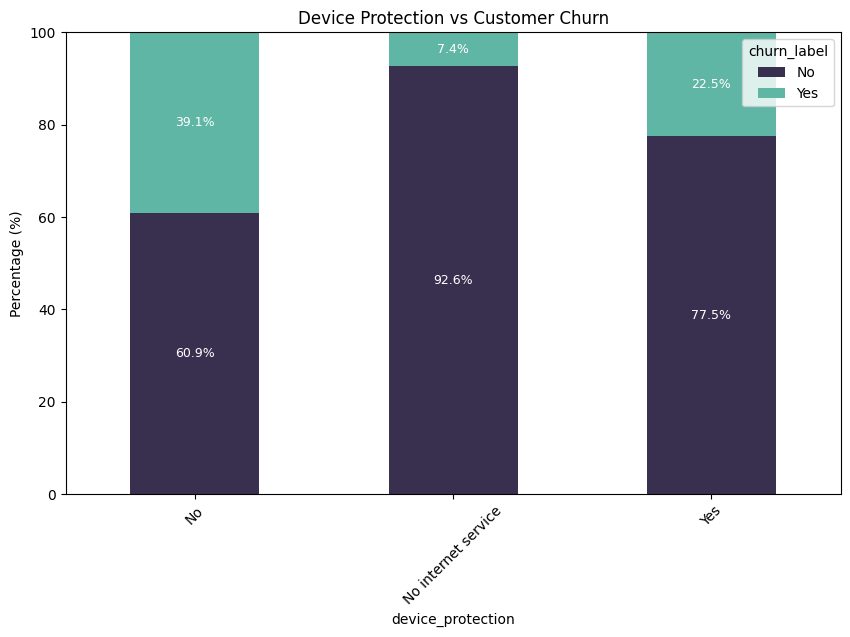

In [140]:
# Plot class distribution for churn_label against device_protection
plot_bi_variate (df_temp, "device_protection", "churn_label", "Device Protection vs Customer Churn")


* Customers who does not have device protection are more likely to churn than those who have

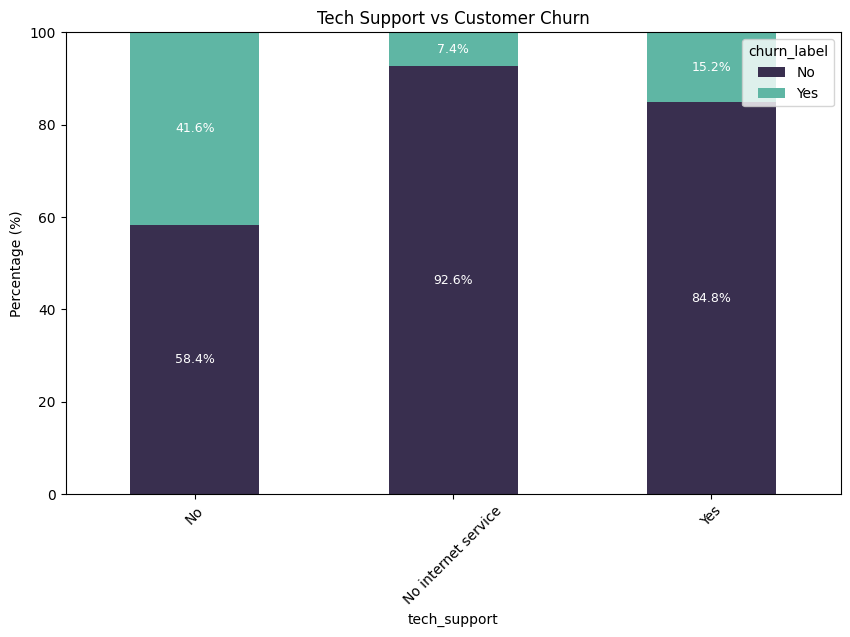

In [141]:
# plot class distribution for churn_label against tech_support
plot_bi_variate (df_temp, "tech_support", "churn_label", "Tech Support vs Customer Churn")


* Customers who does not have tech support are more likely to churn than those who have

C:\Users\moeba\AppData\Local\Temp\ipykernel_46732\2936262108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(x_var)[hue_var]


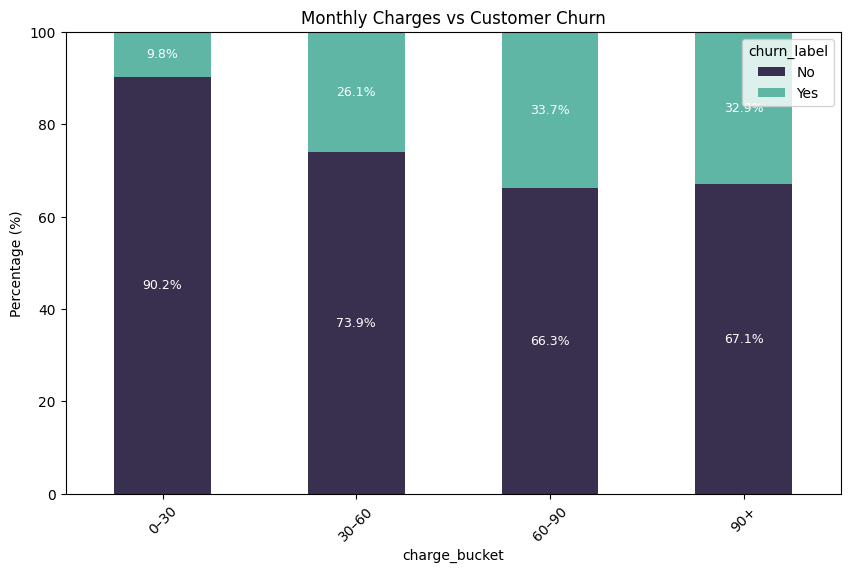

In [142]:
plot_bi_variate (df_temp, "charge_bucket", "churn_label", "Monthly Charges vs Customer Churn")

* customers who in general pay higher monthly charges tend to have a higher risk of churn

#### 3. Data Preprocessing

In [143]:
# copy df_temp to add the derived features
df_cleaned_churn = df_temp.copy()


In [144]:
# Identify constant columns by no of unique values = 1
constant_cols = [col for col in df_cleaned_churn.columns if df_cleaned_churn[col].nunique() == 1]
print("Constant columns: ", constant_cols)

# remove constant columns since they do not add any value to the model
df_cleaned_churn = df_cleaned_churn.drop(columns=constant_cols) 


Constant columns:  []


In [145]:
# remove unnecessary columns
columns_to_remove = ['churn_label']


df_cleaned_churn = df_cleaned_churn.drop(columns=columns_to_remove)
 
 


In [146]:
# check for duplicate rows
print('Number of duplicate rows are: ',
      df_cleaned_churn[df_cleaned_churn.duplicated()].shape[0])


Number of duplicate rows are:  22


In [147]:
# remove duplicate rows
df_cleaned_churn = df_cleaned_churn.drop_duplicates()

##### 3.1 Data Split

* all models will be trained with a 5-fold cross-validation on the whole dataset to get stable & reliable metrics

In [148]:
# separate features and target variable for cv dataset
cv_features = df_cleaned_churn.drop("is_churned", axis=1)
cv_target = df_cleaned_churn["is_churned"]


# split the dataset into 80/20 training and testing sets with stratification keeping original class distribution
train_df, test_df = stratified_split(df_cleaned_churn, target_variable='is_churned', test_size=0.2, random_state=42)

# separate features and target variable for training and testing sets
train_features = train_df.drop("is_churned", axis=1)
train_target = train_df["is_churned"]
test_features = test_df.drop("is_churned", axis=1)
test_target = test_df["is_churned"]

Training data shape:  (5616, 23) (5616,)
Test data shape:  (1405, 23) (1405,)
Number of instances and features in training dataset:  (5616, 24)
Number of non-churned customers:  4131
Number of churned customers:  1485
Number of instances and variables in testing dataset:  (1405, 24)
Number of non-churned customers:  1033
Number of churned customers:  372
Percentages of each class in the train dataset: 
 is_churned
0    73.56
1    26.44
Name: count, dtype: float64
Percentages of each class in the test dataset: 
 is_churned
0    73.52
1    26.48
Name: count, dtype: float64


In [149]:
# group categorical and numerical features so categorical features can passed to encode 
# and numeric features to scaler
categorical_features = train_features.select_dtypes(include=['object','category']).columns.tolist()
numerical_features = train_features.select_dtypes(include=['int64', 'float64']).columns.tolist()

 

In [150]:
print("Categorical features: ", categorical_features)
print("Numerical features: ", numerical_features)

Categorical features:  ['gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method', 'tenure_bucket', 'monthly_charges_quartile', 'charge_bucket', 'service_combo']
Numerical features:  ['tenure_months', 'monthly_charges', 'total_charges']


##### 3.2 Outliers Handling

In [151]:
# handle outliers in numerical features using 3-sigma rule , only for training dataset
    
 
# Calculate mean and standard deviation for all features except for target_variable
for col_name in numerical_features:
        
     mean = np.mean(train_df[col_name])
     std = np.std(train_df[col_name])

     # Define the lower and upper bounds
     lower_bound = mean - 3 * std
     upper_bound = mean + 3 * std

     # Check if feature is of integer type, then modify the bounds to be integers as the upper and lower bands maybe float, so we take floor of the result
         
     if "int" in str(train_df[col_name].dtype) :
          lower_bound=math.floor (lower_bound)
          upper_bound=math.floor (upper_bound)
        
     # Replace outliers with 3s boundaries
        
     train_features.loc[(train_df[col_name] < lower_bound),  col_name] = lower_bound
     train_features.loc[(train_df[col_name] > upper_bound),  col_name] = upper_bound

##### 3.3 Imputation

* Since there is only one numeric field with only 11 null values, I will use simple median imputation to fill missing values, for more complex missing value situations , knn or mice might be a proper solution.

##### 3.4 Feature Selection

* I will use mutual info for calculating feature importance and then rank features based on their scores, and then remove features that has score less or equal to zero

##### 3.5 Scaling & Encoding

 

* I will use standard scaler for scaling and one hot encoding for encoding

In [152]:
# group categorical and numerical features
categorical_features = train_features.select_dtypes(include=['object','category']).columns.tolist()
numerical_features = train_features.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [153]:
# create a ColumnTransformer to impute missing values, standardize numerical features and one-hot encode categorical features
numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

##### 3.6 Class Balancing

I will use SMOTE+ENN method, where SMOTE (over-sampling) is used to generate instances of the minority class, and then use ENN to clean any noise in the generated samples

#### 4. Model Selection

* We have a binary classification problem, and we need to identify churned customers (the minority class is   our focus)
* Majority Class: not churned (0 - No) - negative
* Minortiy Class: chruned (1 - Yes) - positive

* Metrics:
  - accuracy: not helpful since the majority of samples are (not chruned - 0) , if the model is good at predicting the majority class, then the accuracy will be high even if it bad at predicting the minority class

  - recall: our main metric since it is measures the rate of correctly classified positive class

  - roc-auc: also helpful, it measures how good the model at differntiating between the majority and minority  class, (roc-auc of 0.5 considered bad since the model basically is guessing)

  

##### 4.1 Train base models without feature selection

In [130]:
scores_list = []

# list of models to be trained
model_list = [
    ('LogisticRegression', LogisticRegression ()),
    ('KNN', KNeighborsClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('RandomForest', RandomForestClassifier())]

 

# loop through the models list 
for model_name, model_instance in model_list:
    print(f"Training and evaluating model: {model_name}")
    
    # build the model pipeline with transformation, imputation, class balancing and finally the model instance
    
    pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('smotenn', SMOTEENN(random_state=45)),    
        ('classifier', model_instance)
    ])
    
 
 
 
    # fit the model on the whole dataset with 5-fold cross-validation and return the metrics
    accuracy, recall, f1, roc_auc = fit_evaluate_model_cv(pipeline, cv_features, cv_target)
     
    # store the scores
    model_scores = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }
    scores_list.append(model_scores)

# convert the scores to a dataframe and order scores based on roc-auc and recall
scores_df = pd.DataFrame(scores_list)
scores_df = scores_df.sort_values (by=['ROC-AUC','Recall'], ascending=False, inplace=False)
scores_df
    
  
 

 
 

Training and evaluating model: LogisticRegression
Training and evaluating model: KNN
Training and evaluating model: GradientBoosting
Training and evaluating model: XGBoost
Training and evaluating model: RandomForest


,Model,Accuracy,Recall,F1 Score,ROC-AUC
0,LogisticRegression,0.713716,0.884760,0.620468,0.856719
2,GradientBoosting,0.745763,0.832526,0.633996,0.852290
3,XGBoost,0.749893,0.797523,0.627808,0.846360
4,RandomForest,0.748611,0.801831,0.627873,0.841575
1,KNN,0.663438,0.886914,0.582287,0.789387


* based on the initial results, Logistics Regression is the best model with accuracy of 71%, recall of 88%, and roc-auc of 86%

##### 4.2 Train base models with feature selection

In [131]:
preprocess_step = pipeline.named_steps ['preprocess']
cv_transformed = preprocess_step.fit_transform (cv_features, cv_target)
cv_transformed = pd.DataFrame (cv_transformed, columns=preprocess.get_feature_names_out())


In [132]:
cv_transformed

,num__tenure_months,num__monthly_charges,num__total_charges,cat__gender_Female,cat__gender_Male,cat__senior_citizen_No,cat__senior_citizen_Yes,cat__partner_No,cat__partner_Yes,cat__dependents_No,...,cat__monthly_charges_quartile_Q2,cat__monthly_charges_quartile_Q3,cat__monthly_charges_quartile_Q4 (high),cat__charge_bucket_0–30,cat__charge_bucket_30–60,cat__charge_bucket_60–90,cat__charge_bucket_90+,cat__service_combo_Both,cat__service_combo_Internet only,cat__service_combo_Phone only
0,-1.241967,-0.365914,-0.962766,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-1.241967,0.194503,-0.943562,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.997401,1.157358,-0.648285,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.182179,1.328642,0.334231,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.673803,1.292057,1.212869,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,1.611307,-1.453490,-0.383888,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7017,-0.345224,0.663458,-0.131763,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7018,1.611307,1.275428,2.239996,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7019,-0.875118,-1.172450,-0.857564,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [133]:
# calculate mutual info to rank feature importance
mi_scores = mutual_info_classif(cv_transformed, cv_target, random_state=45)

mi_scores = pd.Series(mi_scores, index=cv_transformed.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print(mi_scores)

cat__contract_Month-to-month               0.096306
num__tenure_months                         0.070702
cat__online_security_No                    0.065308
cat__contract_Two year                     0.063223
cat__tech_support_No                       0.060248
                                             ...   
cat__monthly_charges_quartile_Q4 (high)    0.000000
cat__charge_bucket_30–60                   0.000000
cat__tenure_bucket_12-24                   0.000000
cat__gender_Male                           0.000000
cat__online_backup_Yes                     0.000000
Length: 65, dtype: float64


In [134]:
# keep only features with scores > 0
selected_scores = mi_scores [mi_scores> 0]
selected_scores

cat__contract_Month-to-month                     0.096306
num__tenure_months                               0.070702
cat__online_security_No                          0.065308
cat__contract_Two year                           0.063223
cat__tech_support_No                             0.060248
cat__internet_service_Fiber optic                0.058549
num__monthly_charges                             0.048355
cat__payment_method_Electronic check             0.043032
cat__tenure_bucket_48+                           0.042046
num__total_charges                               0.041471
cat__tenure_bucket_1-3                           0.039343
cat__internet_service_No                         0.038339
cat__online_backup_No internet service           0.038282
cat__dependents_Yes                              0.038259
cat__online_backup_No                            0.038110
cat__dependents_No                               0.035185
cat__streaming_tv_No internet service            0.032939
cat__device_pr

In [135]:
# get the selected  feature names
selected_features = selected_scores.index.tolist()

In [136]:
selected_features

['cat__contract_Month-to-month',
 'num__tenure_months',
 'cat__online_security_No',
 'cat__contract_Two year',
 'cat__tech_support_No',
 'cat__internet_service_Fiber optic',
 'num__monthly_charges',
 'cat__payment_method_Electronic check',
 'cat__tenure_bucket_48+',
 'num__total_charges',
 'cat__tenure_bucket_1-3',
 'cat__internet_service_No',
 'cat__online_backup_No internet service',
 'cat__dependents_Yes',
 'cat__online_backup_No',
 'cat__dependents_No',
 'cat__streaming_tv_No internet service',
 'cat__device_protection_No',
 'cat__service_combo_Phone only',
 'cat__tech_support_No internet service',
 'cat__online_security_No internet service',
 'cat__contract_One year',
 'cat__streaming_movies_No internet service',
 'cat__paperless_billing_Yes',
 'cat__device_protection_No internet service',
 'cat__charge_bucket_0–30',
 'cat__monthly_charges_quartile_Q1 (low)',
 'cat__service_combo_Both',
 'cat__online_security_Yes',
 'cat__senior_citizen_Yes',
 'cat__payment_method_Bank transfer (a

In [137]:
# get a subset of the original features based on the selected features
cv_selected= cv_transformed [selected_features]
cv_selected


,cat__contract_Month-to-month,num__tenure_months,cat__online_security_No,cat__contract_Two year,cat__tech_support_No,cat__internet_service_Fiber optic,num__monthly_charges,cat__payment_method_Electronic check,cat__tenure_bucket_48+,num__total_charges,...,cat__tenure_bucket_36-48,cat__streaming_movies_Yes,cat__charge_bucket_60–90,cat__multiple_lines_No phone service,cat__device_protection_Yes,cat__tenure_bucket_less than 1,cat__service_combo_Internet only,cat__phone_service_Yes,cat__phone_service_No,cat__streaming_tv_Yes
0,1.0,-1.241967,0.0,0.0,1.0,0.0,-0.365914,0.0,0.0,-0.962766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,-1.241967,1.0,0.0,1.0,1.0,0.194503,1.0,0.0,-0.943562,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,-0.997401,1.0,0.0,1.0,1.0,1.157358,1.0,0.0,-0.648285,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,-0.182179,1.0,0.0,0.0,1.0,1.328642,1.0,0.0,0.334231,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.673803,1.0,0.0,1.0,1.0,1.292057,0.0,1.0,1.212869,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7016,0.0,1.611307,0.0,1.0,0.0,0.0,-1.453490,0.0,1.0,-0.383888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7017,0.0,-0.345224,0.0,0.0,0.0,0.0,0.663458,0.0,0.0,-0.131763,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7018,0.0,1.611307,1.0,0.0,1.0,1.0,1.275428,0.0,1.0,2.239996,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7019,1.0,-0.875118,0.0,0.0,1.0,0.0,-1.172450,1.0,0.0,-0.857564,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# list of models to be trained
scores_list = []

model_list = [
    ('LogisticRegression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('RandomForest', RandomForestClassifier())]

 

# loop through models list
for model_name, model_instance in model_list:
    print(f"Training and evaluating model: {model_name}")
    
    pipeline = Pipeline(steps=[
        ('smotenn', SMOTEENN()),    
        ('classifier', model_instance)
    ])
    
 
 
 
    # evaluate the model using cross-validation on the whole dataset
    accuracy, recall, f1, roc_auc = fit_evaluate_model_cv(pipeline, cv_selected, cv_target)
     
   # store model scores
    model_scores = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }
    scores_list.append(model_scores)

# save results to dataframe and sort based on roc-auc and recall
scores_df = pd.DataFrame(scores_list)
scores_df = scores_df.sort_values (by=['ROC-AUC','Recall'], ascending=False, inplace=False)
scores_df
    
  
 

 
 

Training and evaluating model: LogisticRegression
Training and evaluating model: KNN
Training and evaluating model: GradientBoosting
Training and evaluating model: XGBoost
Training and evaluating model: RandomForest


,Model,Accuracy,Recall,F1 Score,ROC-AUC
0,LogisticRegression,0.718274,0.870759,0.620491,0.855081
2,GradientBoosting,0.752599,0.814755,0.635314,0.851711
3,XGBoost,0.757300,0.777060,0.628758,0.843868
4,RandomForest,0.757869,0.788368,0.632671,0.840515
1,KNN,0.681669,0.864836,0.589682,0.789264


* so we notice feature selection actually let to a slight decrease in performance for Logistic Regression from 0.88 to 0.87, and also for the other models. This indicate some information loss, so it is better to keep all features.

##### 4.3 Hyperparameters Tuning

In [139]:
categorical_features = cv_features.select_dtypes(include=['object','category']).columns.tolist()
numerical_features = cv_features.select_dtypes(include=['int64', 'float64']).columns.tolist()

# create a ColumnTransformer to impute missing values, standardize numerical features and one-hot encode categorical features
numeric_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [ ]:
# create param grid for the hyperparameters to be tuned for each model
scores_list = []
best_params_grid = {}
best_estimators_grid = {}
model_list = [
    ('LogisticRegression', LogisticRegression()),
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier()),
    ('knn', KNeighborsClassifier())]
 
 
param_grids = {
    'LogisticRegression': {
        'classifier__penalty': [None, 'l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__max_iter': [100,200,300],
        'classifier__solver': ['lbfgs', 'saga'],
        'classifier__class_weight': [None, 'balanced'],
    },
    'RandomForest': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [None, 5, 10, 20, 30],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__min_samples_leaf': [1, 2, 4],
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200, 400, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [2, 3, 4],
        'classifier__subsample': [0.5, 0.8, 1.0],
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 400, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.5, 0.8, 1.0],
        'classifier__colsample_bytree': [0.5, 0.8, 1.0],
    },
    'knn':{
    'classifier__n_neighbors': [3, 5, 7, 9, 15, 25],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['minkowski', 'euclidean', 'manhattan'],
    'classifier__p': [1, 2],             
    'classifier__leaf_size': [20, 30, 40]}
}

 
# loop through models list and apply GridSearchCV to hypertune selected parameters

for model_name, model_instance in model_list:
    print(f"Training and evaluating model: {model_name}\n")
    
    pipeline = Pipeline(steps=[
       ('preprocess', preprocess),
        ('smotenn', SMOTEENN(random_state=45)),    
        ('classifier', model_instance)
    ])
    
    # initialite the grid search, choose roc_auc for scoring and 5-fold cross validation
    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        scoring='roc_auc',   
        n_jobs=-1,
        cv=5,
        
    )
 
    # fit the pipeline
    search.fit (cv_features,cv_target)
 
    # evaluate the pipeline with the best estimator found for the model
    accuracy, recall, f1, roc_auc = evaluate_model(search.best_estimator_, cv_features, cv_target)
     
    # store best parameters and best estimaters for later use
    best_params_grid [model_name] = search.best_params_
    best_estimators_grid [model_name] = search.best_estimator_
    print (f"Best parameters for {model_name}: {search.best_params_}\n" )
   
    # store model scores
    model_scores = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }
    
    print (f"{model_name} best model scores: {model_scores}\n\n")
    scores_list.append(model_scores)

# save the results to dataframe and order based on roc-auc and recall
scores_df = pd.DataFrame(scores_list)
scores_df = scores_df.sort_values (by=['ROC-AUC','Recall'], ascending=False, inplace=False)
scores_df
    
  
  
 

 
 

Training and evaluating model: LogisticRegression

Best parameters for LogisticRegression: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}

LogisticRegression best model scores: {'Model': 'LogisticRegression', 'Accuracy': 0.7308075772681955, 'Recall': 0.8799138395261173, 'F1 Score': 0.6335789065529275, 'ROC-AUC': 0.8617643918149217}


Training and evaluating model: RandomForest

Best parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100}

RandomForest best model scores: {'Model': 'RandomForest', 'Accuracy': 0.7578692493946732, 'Recall': 0.9009154550350027, 'F1 Score': 0.6630994847403884, 'ROC-AUC': 0.8799078434145176}


Training and evaluating model: GradientBoosting

Best parameters for GradientBoosting: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 2, 'classifie

,Model,Accuracy,Recall,F1 Score,ROC-AUC
1,RandomForest,0.757869,0.900915,0.663099,0.879908
3,XGBoost,0.751175,0.864297,0.647569,0.869000
2,GradientBoosting,0.755163,0.864297,0.651248,0.866480
0,LogisticRegression,0.730808,0.879914,0.633579,0.861764
4,knn,0.686939,0.920302,0.608618,0.857670


* we can see after hyperparamters tuning tree-based models outperformed logistic regression, and the best model now is random forest. While accuracy stayed almost the same, recall has signcifacntly increased from 79% to 90%, and roc-auc from 84% to 88%.

##### 4.4 The Winning Model

Training and evaluating model the winning model Random Forest
test Metrics
test Accuracy: 0.7544
test Recall: 0.8952
test F1 Score: 0.6588
test  ROC-AUC Score: 0.8747

test  Classification Report



              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1033
           1       0.52      0.90      0.66       372

    accuracy                           0.75      1405
   macro avg       0.74      0.80      0.73      1405
weighted avg       0.84      0.75      0.77      1405



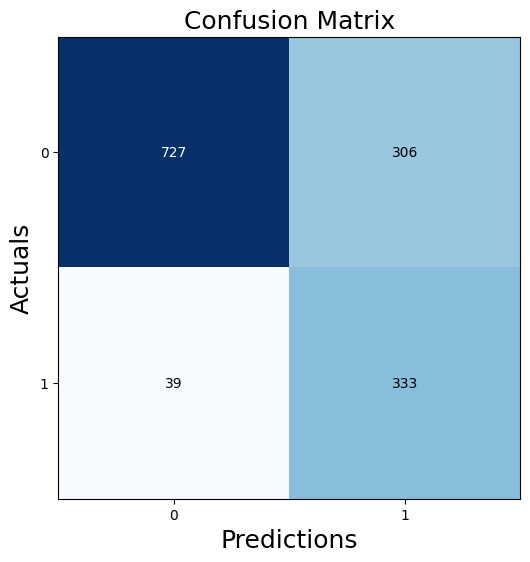

In [ ]:
# Evaluate the best model on the test dataset

print (f"Training and evaluating model the winning model Random Forest")

# get best estimator for random forest from the grid  
best_model = best_estimators_grid ['RandomForest']
  
# evaluate the winning model and print the metrics
evaluate_model(best_model, test_features, test_target,doPrint=True)
     
   
 

 
 